# Initialization

In [1]:
%cd ../covid_households
import recipes as recipes
from settings import model_constants
from settings import STATE
import numpy as np

/Users/thayer/covid_households/covid_households


In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')
results = recipes.Results.load("/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8/repaired_counts")

In [3]:
extra_results = recipes.Results.load('/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8/experiment-02-23-21-45', from_parts=True)
extra_results2 = recipes.Results.load('/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8/experiment-02-23-21-48')

extra = extra_results.combine(extra_results2)
fuller_results = results.combine(extra)
fuller_results = fuller_results.repair_missing_counts()

Compiling results df from parts. Treating all files with extension .parquet as parts.


In [4]:
results = fuller_results

In [5]:
results.find_frequencies(inplace=True)

s80  p80  SAR   size  infections
0.1  0.1  0.15  2     1             0.91224
                      2             0.08776
                3     1             0.82928
                      2             0.12596
                      3             0.04476
                                     ...   
0.8  0.8  0.60  8     4             0.00008
                      5             0.00004
                      6             0.00032
                      7             0.00544
                      8             0.98848
Name: count, Length: 1689310, dtype: float64

# Junk

In [5]:
def resample_freqs(s, n):
    return results.resample((0.5, 0.5, 0.24), {s:n})['count']/n

i1 = resample_freqs(8, 50000)
i2 = resample_freqs(8, 50000)

i1, i2

(trial  sample s80  sample p80  sample SAR  size  infections
 0      0.5         0.5         0.24        8     1             0.26364
                                                  2             0.09820
                                                  3             0.07106
                                                  4             0.07622
                                                  5             0.09336
                                                  6             0.12090
                                                  7             0.14862
                                                  8             0.12800
 Name: count, dtype: float64,
 trial  sample s80  sample p80  sample SAR  size  infections
 0      0.5         0.5         0.24        8     1             0.26982
                                                  2             0.09788
                                                  3             0.07114
                                                  4     

In [61]:
np.average(((i1 - i2)/i1)*100)

-0.09600557517333869

# Violin figures

`null_freqs` represents the frequencies we observe in the absence of heterogeneity. We use it to calculate the MLE along the restriction where heterogeneity is not present.

In [5]:
freq = results.df['frequency']
s80_l = freq.index.get_level_values(0)
p80_l = freq.index.get_level_values(1)

null_freqs = freq[(s80_l == 0.8) & (p80_l == 0.8)]
null_freqs

s80  p80  SAR   size  infections
0.8  0.8  0.15  2     1             0.84270
                      2             0.15730
                3     1             0.71702
                      2             0.21632
                      3             0.06666
                                     ...   
          0.40  8     4             0.00434
                      5             0.00644
                      6             0.01922
                      7             0.10160
                      8             0.81162
Name: frequency, Length: 910, dtype: float64

In [ ]:
def make_mles(logl, parameters, population, parameter_set):
    """Takes the log likelihood surface for each trial and returns the MLEs.

    Args:
        logl (Pandas.DataFrame): the loglikelihood surface. Indexed by at least `trial` which represent different observations
        parameters (list): a list of strings that correspond to labels in the dataframe for each of our parameters in the MLE
        population (_type_): _description_
        parameter_set (_type_): _description_

    Returns:
        _type_: _description_
    """    
    fits = logl.groupby('trial').idxmax()
    fits = pd.DataFrame(fits.tolist())
    fits.columns = ["baseline " + key for key in parameters] + ['trial'] + ["MLE_" + key for key in parameters]
    fits = fits.drop(["baseline " + key for key in parameters], axis=1).set_index('trial')
    
    fits['sample size'] = sum([k*v for k,v in population.items()])
    fits['population mix'] = list(population.keys()) * len(fits)
    fits ['parameters'] = [parameter_set] * len(fits)
    return fits

Choose the different combinations of parameters / sample sizes / household sizes to try.

In [2]:
import covid_households.likelihood as likelihood
sample_sizes = [500, 1500, 3000, 5000, 10000]
population_mixes = [(8,), (5,), (2,), (8,4), (8,5), (8,7), (8,2)]#, (2,3,4,5,6,7,8)]
parameter_sets = [(0.6, 0.6, 0.3), (0.4, 0.4, 0.2), (0.8, 0.5, 0.25), (0.5, 0.8, 0.25)]

ModuleNotFoundError: No module named 'covid_households'

Run the fits at all the combinations (create the population sample using statistical resampling — not forward simulation). Aggregate fits against the full surface in `fits_dfs` and the fits on the restriction that there is no heterogeneity in `null_hypoth_fits_dfs`.

In [1]:
trials = 150

fit_dfs = []
null_hypoth_fits_dfs = []
for sample_size in sample_sizes:
    for population_mix in population_mixes:
        for parameter_set in parameter_sets:
            population_per_size = sample_size // len(population_mix)
            population = {s:population_per_size for s in population_mix}
            samples = results.resample(parameter_set, population, trials=trials)
            print(samples)
            logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
            fits = make_mles(logl, results.metadata.parameters, population, parameter_set)
            fit_dfs.append(fits)

            null_hypoth_logl = likelihood.logl_from_frequencies_and_counts(null_freqs, samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
            null_hypoth_fits = make_mles(null_hypoth_logl, results.metadata.parameters, population, parameter_set)
            null_hypoth_fits_dfs.append(null_hypoth_fits)

NameError: name 'sample_sizes' is not defined

Combine results into single dfs.

In [ ]:
fit_df = pd.concat(fit_dfs)
null_fit_df = pd.concat(null_hypoth_fits_dfs)
fit_df
null_fit_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')
#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']
for k,g in fit_df.groupby(['population mix', 'sample size', 'parameters']):
    plt.figure()
    fig, axes = plt.subplots(1,4, dpi=800, sharey=True)
    print(k)
    print(g.mean())
    population_mix, sample_size, parameters = k
    plt.suptitle(f"{sample_size} individuals equally mixed among size {population_mix} hhs. \ns80, p80, SAR={parameters}")
    i = 0
    for c in g.columns:
        if 'MLE' not in c:
            continue
        if 's80' in c or 'p80' in c:
            parameter_index = 0 if 's80' in c else 1
            #mi, ma = min_dict[parameters[parameter_index]], max_dict[parameters[parameter_index]]
            mi, ma = 0.1, 0.8
            axes[i].set_ylim(mi, ma)
        if 'SAR' in c:
            pass
            #axes[i].set_ylim(0.1, 0.5)
            axes[i].set_ylim(0.1, 0.8)
        if parameters[i] == 0.8:
            axes[i].axhline(0.795, color=axline_colors[i])
        else:
            axes[i].axhline(parameters[i], color=axline_colors[i])
        sns.violinplot(y=c, data=g, ax=axes[i], orient="v", color=colors[i])
        axes[i].set(xlabel=xlabels[i], ylabel='')
        i += 1
    null_fit_slice = null_fit_df.groupby(['population mix', 'sample size', 'parameters']).get_group(k)
    #axes[3].set_ylim(0.1, 0.5)
    axes[3].set_ylim(0.1, 0.8)
    # plot the true SAR on the null hypothesis SAR
    axes[3].axhline(parameters[2], color='mistyrose')
    axes[3].set(xlabel=xlabels[3], ylabel='')
    sns.violinplot(y=null_fit_slice['MLE_SAR'], data=null_fit_slice, ax=axes[3], orient="v", color='indianred')
    #axes[3].set(ylabel='MLE of SAR assuming no heterogeneity')
    fig.tight_layout()
    plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', f'{k}' + '.jpg'))

    

In [ ]:
null_fits = null_fit_df['MLE_SAR'].copy()
null_fits.name = 'No traits \n MLE for SAR'
version_2_df = pd.concat([fit_df, null_fits], axis=1)

params = ['population mix', 'sample size', 'parameters']
for k,g in version_2_df.groupby(params):
    data = g.drop(params, axis=1)
    plt.figure(dpi=800)
    fig = sns.violinplot(data=data)
    fig.set_ylim(0.1, 0.8)
    plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', 'v2' + f'{k}' + '.jpg'))
    break

In [ ]:
means = fit_df.groupby(['population mix', 'sample size', 'parameters']).mean()
stds = fit_df.groupby(['population mix', 'sample size', 'parameters']).std()
stds.columns = ['STD_' + s for s in stds.columns]

statistics = pd.concat([means, stds], axis=1)
with open('/Users/thayer/covid_households/batched_figs/stats.csv', 'w') as f:
    statistics.to_csv(f)

In [ ]:
stds.sort_values(by='STD_MLE_s80')
with open('/Users/thayer/covid_households/batched_figs/stds.csv', 'w') as f:
    stds.to_csv(f)

with open('/Users/thayer/covid_households/batched_figs/means.csv', 'w') as f:
    means.to_csv(f)

# Power calculation

In [31]:
#   Two  | Three	 Four     Five    Six    Seven or more
# 45,515 | 19,523 | 16,098 | 7,577 | 2,635 |     1,611
# https://www.census.gov/data/tables/time-series/demo/families/households.html
population = {4:100}
basline_parameters = (0.5, 0.5, 0.2)
sar_range = np.linspace(0.25, 0.51, 14)
trials = 500

pvalues = []
for sar in sar_range:
    pvalues_for_one_sar = []
    # replace baseline sar with target sar
    parameters = list(basline_parameters)
    parameters[2] = float(f'{sar:0.3f}')
    parameters = tuple(parameters)
    print(parameters)
    for t in range(trials):
        samples = results.resample(basline_parameters, population, trials=1)
        baseline_logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
        posterior = np.exp(baseline_logl.sort_values(ascending=False)-baseline_logl.max())
        posterior = posterior/posterior.sum()
        baseline_probability_over_sars = posterior.groupby('SAR').sum()

        samples = results.resample(parameters, population, trials=1)
        logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
        posterior = np.exp(logl.sort_values(ascending=False)-logl.max())
        posterior = posterior/posterior.sum()
        probability_over_sars = posterior.groupby('SAR').sum()

        sample1 = np.random.choice(baseline_probability_over_sars.index, 10000, p=baseline_probability_over_sars)
        sample2 = np.random.choice(probability_over_sars.index, 10000, p=probability_over_sars)

        pvalue = np.count_nonzero((sample1-sample2) < 0)/len(sample1)
        pvalues_for_one_sar.append(pvalue)
    pvalues.append(pvalues_for_one_sar)

(0.5, 0.5, 0.25)


/Users/thayer/covid_households/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.5, 0.5, 0.27)
(0.5, 0.5, 0.29)
(0.5, 0.5, 0.31)
(0.5, 0.5, 0.33)
(0.5, 0.5, 0.35)
(0.5, 0.5, 0.37)
(0.5, 0.5, 0.39)
(0.5, 0.5, 0.41)
(0.5, 0.5, 0.43)
(0.5, 0.5, 0.45)
(0.5, 0.5, 0.47)
(0.5, 0.5, 0.49)
(0.5, 0.5, 0.51)


In [32]:
pvalue_df = pd.DataFrame(pvalues, index=[float(f'{sar:0.3f}') for sar in sar_range]).transpose()
pvalue_df

,0.25,0.27,0.29,0.31,0.33,0.35,0.37,0.39,0.41,0.43,0.45,0.47,0.49,0.51
0,0.8756,0.9208,0.8892,0.9397,0.9991,0.9775,0.9939,0.9998,1.0000,0.9883,1.0000,1.0,1.0000,1.0
1,0.9528,0.9606,0.9249,0.9742,0.9884,0.9996,0.9926,0.9994,1.0000,1.0000,1.0000,1.0,1.0000,1.0
2,0.9201,0.9899,0.9230,0.9984,0.8364,0.9710,0.9908,0.9998,0.9998,0.9998,1.0000,1.0,1.0000,1.0
3,0.5582,0.8730,0.9209,0.9925,0.9921,0.4470,0.9888,1.0000,1.0000,0.9994,0.9948,1.0,1.0000,1.0
4,0.7098,0.7571,0.9841,0.9836,0.9553,0.9998,0.9994,1.0000,0.9988,1.0000,1.0000,1.0,1.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.8582,0.9792,0.8660,0.9811,0.9816,0.9994,0.9999,0.9933,1.0000,1.0000,0.9980,1.0,0.9999,1.0
496,0.8647,0.8743,0.9911,0.9979,0.9915,0.9471,0.9946,0.9999,1.0000,0.9999,1.0000,1.0,0.9859,1.0
497,0.7192,0.9590,0.8290,0.9805,0.9176,0.9916,0.9547,1.0000,0.9997,1.0000,1.0000,1.0,1.0000,1.0
498,0.5932,0.9595,0.9811,0.9976,0.9998,0.9748,0.9925,0.9997,1.0000,1.0000,1.0000,1.0,1.0000,1.0


In [41]:
power90 = ((pvalue_df > 0.90).sum()/trials)#.plot()
power90.name = 'power p=0.9'

In [42]:
power95 = (pvalue_df > 0.95).sum()/trials
power95.name = 'power p=0.95'

Text(0.5, 0, 'SAR in heightened group')

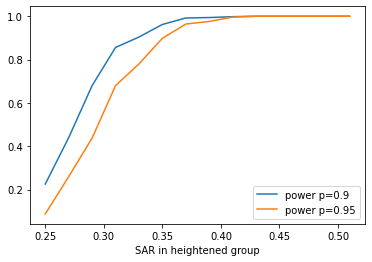

In [50]:
import matplotlib.pyplot as plt
power_df = pd.concat([power90, power95], axis=1)
power_df.plot()
plt.xlabel('SAR in heightened group')

In [ ]:
brendan_fit_df = pd.concat(brendan_fit_dfs)

In [ ]:
clusters = []
for k,g in brendan_fit_df.groupby('parameters'):
    clusters.append(g)

In [ ]:
((clusters[0]['MLE_SAR'] + 0.1) < clusters[1]['MLE_SAR']).value_counts()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')
#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']
for k,g in brendan_fit_df.groupby(['population mix', 'sample size', 'parameters']):
    plt.figure()
    fig, axes = plt.subplots(1,3, dpi=800, sharey=True)
    print(k)
    print(g.mean())
    population_mix, sample_size, parameters = k
    plt.suptitle(f"{sample_size} individuals equally mixed among size {population_mix} hhs. \ns80, p80, SAR={parameters}")
    i = 0
    for c in g.columns:
        if 'MLE' not in c:
            continue
        if 's80' in c or 'p80' in c:
            parameter_index = 0 if 's80' in c else 1
            mi, ma = 0.1, 0.8
            axes[i].set_ylim(mi, ma)
        if 'SAR' in c:
            pass
            #axes[i].set_ylim(0.1, 0.5)
            axes[i].set_ylim(0.1, 0.8)
        if parameters[i] == 0.8:
            axes[i].axhline(0.795, color=axline_colors[i])
        else:
            axes[i].axhline(parameters[i], color=axline_colors[i])
        sns.violinplot(y=c, data=g, ax=axes[i], orient="v", color=colors[i])
        axes[i].set(xlabel=xlabels[i], ylabel='')
        i += 1

    fig.tight_layout()
    plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs/brendan', f'{k}' + '.jpg'))
    #break
    #input()

In [ ]:
import numpy as np
expected_s80s = np.linspace(0.1, 0.8, 36)
expected_p80s = np.linspace(0.1, 0.8, 36)
expected_SARs = np.linspace(0.15, 0.40, 26)

decimal_places = 3

for s80, p80, SAR in zip(expected_s80s, expected_p80s, expected_SARs):
    # touch everything in the convex area that we expect to exist
    results.df.loc[float(f"{s80:.{decimal_places}f}"), float(f"{p80:.{decimal_places}f}"), float(f"{SAR:.{decimal_places}f}")]
    #print(results.df.loc[float(f"{s80:.{decimal_places}f}"), float(f"{p80:.{decimal_places}f}"), float(f"{SAR:.{decimal_places}f}")])
    #break